In [1]:
### ---- (1) ---- ####
#Import Python libraries

import os
import sys
sys.path.append('../../PyScripts')
import xarray as xr
import matplotlib
from scipy.signal import freqz
from matplotlib import pyplot as plt
import numpy as np
import funcs
import lcmaps
from datetime import datetime,timedelta
from scipy import signal, ndimage
from scipy.signal import butter, lfilter
import cmasher as cmr
import colorcet as cc
import multiprocessing
from joblib import Parallel,delayed

#Import cartopy functions for mapping
from cartopy.feature import NaturalEarthFeature,BORDERS,LAKES,COLORS
import cartopy.crs as crs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from metpy.plots import colortables
import colorcet as cc
import cmasher as cmr
from metpy import calc

#Retrieve temp colormap    
cmapp_temp = lcmaps.thetae()
#Retrieve perceptually uniform colorbar from colorcet
cmapp = cc.cm.rainbow_bgyrm_35_85_c71

#Set format for datetime objects
fmt = '%Y%m%d_%H%M'

#Import metpy tools
from metpy.calc import reduce_point_density
from metpy.plots import StationPlot

#Retrieve perceptually uniform colorbar from colorcet
cmapp = cc.cm.rainbow_bgyrm_35_85_c71

#Set format for datetime objects
fmt = '%Y%m%d_%H%M'

# Download/add state and coastline features for cartopy 
states = NaturalEarthFeature(category="cultural", scale="10m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")

land_50m = NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='k',
                                        facecolor='none')

#Define function to add map data to matplotlib plot
def add_map(ax,clr,lw):
    ax.add_feature(states)
    ax.add_feature(BORDERS)
    ax.add_feature(land_50m)
    ax.add_feature(states,edgecolor=clr,lw=lw)
    ax.add_feature(LAKES, edgecolor=clr)

#Define function to add latitude/longitude grid lines to cartopy/matplotlib plot
def add_gridlines(ax,xl,yl,clr, fs):
    gl = ax.gridlines(crs=crs.PlateCarree(), draw_labels=True,
                      linewidth=0.25, color=clr, alpha=1, linestyle='--')

    gl.xlabels_bottom = xl
    gl.xlabels_top = False
    gl.ylabels_left = yl
    gl.ylabels_right = False

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': fs, 'color': clr}
    gl.ylabel_style = {'size': fs, 'color': clr}
    return gl

#Get Composite Reflectivity colormap from metpy
ctable1 = 'NWSStormClearReflectivity'
cmapp = cc.cm.rainbow_bgyrm_35_85_c71
norm, cmapp_radar = colortables.get_with_steps(ctable1, 244, 244)

#Define function to mask pressure analyses over water
def mask_grid(arr):
    arr = np.ma.masked_where(landsea==0,arr)
    return arr

#Define bounding box for data
minLng = -97.5; maxLng = -88.5; minLat = 30; maxLat= 35
#Define function to read and subset a land/sea boolean grid
def get_landsea():
    ds_land = xr.open_dataset('../../../data/Static/landsea.nc')
    ds_land = funcs.subset(ds_land,minLat,maxLat,minLng,maxLng)
    landsea = ds_land['LANDSEA'].values
    landsea = np.pad(landsea, ((0,1),(0,1)), 'edge')
    ds_land.close()
    return landsea

#Retrieve land-sea boolean grid.
landsea = get_landsea()
landsea = landsea[:-1,:-1] #Adjust bounds 

#Increase with of notebook to fill screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#---- (2) ---- #
#Retrieve surface analyses variables for example case
dg1 = xr.open_dataset('../../../data/Cases/24hr_positive_anal.nc')
alts_smart = dg1['alts_smart'].values #Smartphone Altimeter
alts_madis = dg1['alts_madis'].values #MADIS Altimeter
temp = dg1['temp'].values #2-m temperature
dwpt = dg1['dwpt'].values #2-m dew point temperature
uwnd = dg1['uwnd'].values*1.94384449 #zonal wind (convert to knts)
vwnd = dg1['vwnd'].values*1.94384449 #meridional wind (convert to knts)

#Retrieve perturbation analyses for example case
dg2 = xr.open_dataset('../../../data/Cases/24hr_positive_pert.nc')
#Subset analysis domain
dg2 = funcs.subset(dg2,minLat,maxLat,minLng,maxLng)
#Retrieve composite reflectivity analyses
dgr = xr.open_dataset('../../../data/Radar/24hr_cref_masked.nc')

#Demonstrate how mesoscale features are retrieved by bandpass filtering time-series from Case Study I.
matplotlib.rcParams.update({'font.size': 18})
#get list of analysis times 
dts = np.array([datetime.utcfromtimestamp(d) for d in dg2['Valid'].values/1e9])

alts_meso_smart = dg2['alts_smart'].values #smarthone altimeter perturbation
alts_meso_madis = dg2['alts_madis'].values #MADIS altimeter perturbation
temp_meso = dg2['temp'].values #temperature perturbation
dwpt_meso = dg2['dwpt'].values #dewpoint perturbation
uwnd_meso = dg2['uwnd'].values*1.94384449 #zonal wind perturbation (knts)
vwnd_meso = dg2['vwnd'].values*1.94384449 #meridional wind perturbation (knts)
#Grid coordinates
lngs = dg2['longitude'].values 
lats = dg2['latitude'].values

In [3]:
#Get dimensions of pressure anlaysis
ys = alts_smart.shape[1] #lat dim
xs = alts_smart.shape[2] #lng dim

#Set upper and lower limits of band pass filter
highcut = 1/(3600*2)
lowcut = 1/(3600*6)

fs = 1/300.0 #Set temporal frequency of analysis (in hertz)

#Define highpass/bandpass filter function
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs #nyquist frequency
        low = lowcut / nyq #lower limit filter
        high = highcut / nyq #upper limit of filter
        b, a = butter(order, [low, high], btype='band') #Perform bandpass
        #b, a = butter(order, [high], btype = 'highpass')
        return b, a

#Function to perform band pass filtering
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = signal.filtfilt(b, a, data)
        return y

#Filter time-series
def filter_ts(vvar,order=5):
        meso = butter_bandpass_filter(vvar, lowcut, highcut, fs, order)
        return meso

#Function to perform bandpass filtering of pressure time series at grid point (y,x)
def perform_filter(vvar,x,y,order=5):
    if (y == xs-1):
            print(x)
    
    #Get bandpass filtered time-series
    meso = filter_ts(vvar,order=5)
    return meso

/tmp/ipykernel_1988/1827409477.py:16: RuntimeWarning: divide by zero encountered in true_divide
  ff_min = (1/ff)/60.0 #define ordinate


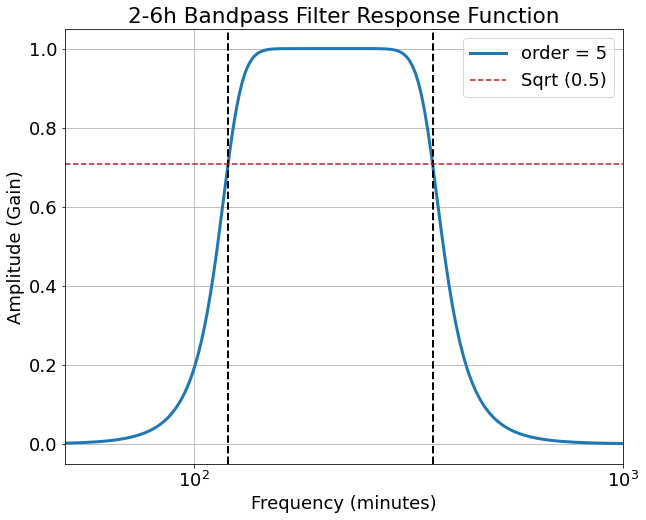

In [4]:
#---- (3) ---- #
#Show squared magnitude response of 2-6h bandpass filter across a range of frequencies
matplotlib.rcParams.update({'font.size': 18})
from scipy.signal import freqz

# Plot the frequency response for a few different orders.
fig1 = plt.figure(figsize=(10,8))
plt.clf()
ax1 = plt.gca() 
#Plot fifth order filter
for order in [5]:
    #Perform bandpass filtering
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    ff = ((fs*0.5/np.pi)*w) #Define abssica 
    ff_min = (1/ff)/60.0 #define ordinate
    #Plot filter
    plt.plot(ff_min, abs(h), label="order = %d" % order,lw=3)
    
#Set y-scale to log
ax1.set_xscale('symlog')
#Add bands
plt.axvline(x=2*60,color='k',linestyle='--',lw=2)
plt.axvline(x=6*60,color='k',linestyle='--',lw=2)
#Mark sqrt(half-gain)
plt.axhline(y=np.sqrt(0.5),color='firebrick',linestyle='--',label='Sqrt (0.5)')
#Label Plot
plt.xlabel('Frequency (minutes)')
plt.ylabel('Amplitude (Gain)')
plt.title('2-6h Bandpass Filter Response Function')
plt.xlim([50,1e3]) #Limit x-range
plt.grid(True)
plt.legend(loc='best')
plt.show()

In [9]:
#Set time/date format
fmt = '%Y%m%d_%H%M'
#Convert datetime objects to list of dates
dtlist = [datetime.strftime(d,fmt) for d in dts]

#Define function to retrieve observations from NetCDF file
def get_vvar_all(varname,ntyp,ddate):
    #Open observation file
    dsm = xr.open_dataset('../../../data/MADIS/'+ntyp+'_'+varname+'_5min_'+ddate+'.nc')
    #Subset observations
    dsm = funcs.subset(dsm,minLat,maxLat,minLng,maxLng)
    #Retrieve observation time-series
    if (varname == 'wind'):
        vvar1 = dsm['uwind'].values
        vvar2 = dsm['vwind'].values
    else:
        vvar = dsm[varname].values
    
    #Retrieve observation locations
    vlats,vlngs = dsm['latitude'].values,dsm['longitude'].values
    dsm.close()
    #Return observation and location
    if (varname == 'wind'):
        return vvar1,vvar2,vlats,vlngs
    else:
        return vvar,vlats,vlngs

#Set minimimum station spacing (in decimal degrees) for metpy spatial filtering
dxy = 0.25
#Define point at which to extract time-series
mlat = 32.5; mlng = -91.4
#Find index of grid point closest to this point
yidx = np.argmin(abs(lats-mlat))
xidx = np.argmin(abs(lngs-mlng))
#Define 2-D coordinate grid
X,Y = np.meshgrid(lngs,lats)

#Define function to plot/save pressure and composite reflectivity analysis 
def plot_anal1(d,ddate): 
    d = d+144
    matplotlib.rcParams.update({'font.size': 20})
    #Get 5-min reflectivity and altimeter analysis
    rfl_2d = dgr['REFL'][d].values
    #Mask altimeter anlaysis over water
    alts_meso_2d_smart = mask_grid(alts_smart[d])
    #Smooth altimeter analysis for contouring
    alts_meso_2d_smart_smooth = ndimage.gaussian_filter(alts_smart[d],sigma=2.5)
    
    #Mask altimeter anlaysis over water
    alts_meso_2d_madis = mask_grid(alts_madis[d])
    #Smooth altimeter analysis for contouring
    alts_meso_2d_madis_smooth = ndimage.gaussian_filter(alts_madis[d],sigma=2.5)
    
    #Initialize figure
    fig =plt.figure(figsize=(20,11))
    
    #Mask altimeter anlaysis over water    
    uwnd_meso_2d = mask_grid(uwnd[d])
    #Smooth altimeter analysis for contouring
    uwnd_meso_2d_smooth = ndimage.gaussian_filter(uwnd[d],sigma=2.5)
        
    #Mask altimeter anlaysis over water        
    vwnd_meso_2d = mask_grid(vwnd[d])
    #Smooth altimeter analysis for contouring
    vwnd_meso_2d_smooth = ndimage.gaussian_filter(vwnd[d],sigma=2.5)
    
    levs = np.int32(np.arange(1005,1026,1)) #[-2,-1.5,-1,-0.5,0.5,1,1.5,2]
    #Plot pressure analysis
    dxx = 10
    
    #Retrieve smartphone and MADIS observations by type and network
    salts,slats,slngs = get_vvar_all('altimeter','smartphone_full',ddate)
    malts,mlats,mlngs = get_vvar_all('altimeter','madis',ddate)
    mtemp,tlats,tlngs = get_vvar_all('temperature','madis',ddate)
    mdwpt,dlats,dlngs = get_vvar_all('dewpoint','madis',ddate)
    muwnd,mvwnd,wlats,wlngs = get_vvar_all('wind','madis',ddate)

    #Convert temperature and wind observations to C and knts, respectively
    obs_vars = [salts,malts,mtemp-273.15,mdwpt-273.15,muwnd*1.94384449,mvwnd*1.94384449]
    #Get locations of observations
    obs_lats = [slats,mlats,tlats,dlats,wlats]
    obs_lngs = [slngs,mlngs,tlngs,dlngs,wlngs]
    
    #Plot composite reflectivity analysis overlaid with point observations
    ax0 = plt.subplot2grid((2,4),(0, 1),colspan=2,projection=crs.PlateCarree())
    add_map(ax0,'dimgray',1) #Add States/borders
    add_gridlines(ax0,True,True,'k',20) #Add grid lines and x/y labels  
    #Plot composite reflectivity
    im = ax0.imshow(np.ma.masked_where(rfl_2d<=20,rfl_2d),origin='lower',extent=[minLng,maxLng,minLat,maxLat],cmap=cmapp_radar,vmin=-32,vmax=90,zorder=5,alpha=0.65)
    #Set grid bounds
    ax0.set_xlim([minLng,maxLng])
    ax0.set_ylim([minLat,maxLat])
    #Set title and colorbar info
    ax0.set_title('a) Composite Reflectivity and MADIS Observations',fontsize=20)
    cb=plt.colorbar(im,fraction=0.03)
    cb.ax.set_title('($dBZ$)',y=1.02,fontsize=18)
    cb.ax.tick_params(labelsize=18)
    #Loop through each variable type and add variable to station plot
    for j in range(1,5):
        point_locs = np.array([obs_lngs[j],obs_lats[j]]).T
        #Spatially filter observations to ensure visibility
        pi = reduce_point_density(point_locs, dxy)
        ax0.scatter(obs_lngs[j][pi],obs_lats[j][pi],c='k',s=5,zorder=5)
        stationplot = StationPlot(ax0, obs_lngs[j][pi],obs_lats[j][pi],clip_on=True, transform=crs.PlateCarree(), fontsize=9, zorder=5)
        if (j == 1):
                stationplot.plot_parameter('NE', obs_vars[j][pi],formatter=lambda v: format(10 * v, '.0f')[-3:],zorder=5)
        if (j == 2):
                stationplot.plot_parameter('NW', obs_vars[j][pi], color='red',zorder=5)
        if (j == 3):
                stationplot.plot_parameter('SW', obs_vars[j][pi],color='darkgreen',zorder=5)
        if (j == 4):
                stationplot.plot_barb(obs_vars[j][pi], obs_vars[j+1][pi],zorder=5)
    
    ax1 = plt.subplot2grid((2,4),(1, 0),colspan=2,projection=crs.PlateCarree())    
    add_map(ax1,'dimgray',1) #Add States/borders
    add_gridlines(ax1,True,True,'k',20) #Add grid lines and x/y labels  
    #Plot smartphone altimeter analysis
    im = ax1.imshow(alts_meso_2d_smart,origin='lower',extent=[minLng,maxLng,minLat,maxLat],cmap=cmapp,vmin=1005,vmax=1025,alpha=0.9)
    #Contour pressure every 1 hPa
    CS = ax1.contour(X,Y,mask_grid(alts_meso_2d_smart_smooth),levels=levs,colors='k',alpha=1)
    ax1.clabel(CS, CS.levels, inline=True, fmt="%1.0f", fontsize=14, colors='k') #Label contours
    #Add MADIS wind barbs
    q1 = ax1.barbs(X[::dxx,::dxx],Y[::dxx,::dxx],uwnd_meso_2d[::dxx,::dxx],vwnd_meso_2d[::dxx,::dxx]) 
    #Set grid bounds
    ax1.set_xlim([minLng,maxLng])
    ax1.set_ylim([minLat,maxLat])
    #Set title
    ax1.set_title('b) Smartphone Pressure (hPa) and MADIS Wind (kts)',fontsize=20)
    cb=plt.colorbar(im,fraction=0.027,ticks=levs[::5]) #Shrink colorbar to fit plot height
    cb.ax.set_yticklabels(levs[::5]) #Set colorbar ticklabels
    cb.ax.set_title('($hPa$)',y=1.02,fontsize=18) #Set colorbar title
    cb.ax.tick_params(labelsize=18) #Set colorbar tick size

    #Plot MADIS pressure analysis
    #ax2 = plt.subplot(322,projection=crs.PlateCarree()) #define projection
    ax2 = plt.subplot2grid((2,4),(1, 2),colspan=2,projection=crs.PlateCarree())    
    add_map(ax2,'dimgray',1) #Add States/borders
    add_gridlines(ax2,True,False,'k',20) #Add grid lines and x/y labels  
    im = ax2.imshow(alts_meso_2d_madis,origin='lower',extent=[minLng,maxLng,minLat,maxLat],cmap=cmapp,vmin=1005,vmax=1025,alpha=0.9)
    #Contour pressure every 1 hPa
    CS = ax2.contour(X,Y,mask_grid(alts_meso_2d_madis_smooth),levels=levs,colors='k',alpha=1)
    ax2.clabel(CS, CS.levels, inline=True, fmt="%1.0f", fontsize=14, colors='k') #Label contours
    #Add MADIS wind barbs
    q2 = ax2.barbs(X[::dxx,::dxx],Y[::dxx,::dxx],uwnd_meso_2d[::dxx,::dxx],vwnd_meso_2d[::dxx,::dxx]) 
    #Set grid bounds
    ax2.set_xlim([minLng,maxLng])
    ax2.set_ylim([minLat,maxLat])
    #Set title
    ax2.set_title('c) MADIS Pressure (hPa) and Wind (kts)',fontsize=20)   
    cb=plt.colorbar(im,fraction=0.027,ticks=levs[::5]) #Shrink colorbar to fit plot height
    cb.ax.set_yticklabels(levs[::5]) #Set colorbar ticklabels
    cb.ax.set_title('($hPa$)',y=1.02,fontsize=18) #Set colorbar title
    cb.ax.tick_params(labelsize=18) #Set colorbar tick size

    #Save figure 
    fig.canvas.draw()
    plt.tight_layout()
    #Adjust plot and add suptitle.
    plt.subplots_adjust(top=0.9)
    plt.suptitle('Smartphone and MADIS Surface Analysis: '+ddate[9:13]+' UTC '+ddate[4:6]+'/'+ddate[6:8]+'/'+ddate[0:4],fontsize=26)
    cnt = d-144
    if (cnt < 10):
        cs = '00'+str(cnt)
    elif ((cnt >= 10) and (cnt < 100)):
        cs = '0'+str(cnt)
    else:
        cs = str(cnt)
    #Save figure
    plt.savefig('../../../Plots/Analysis/surface_obj_pres_analysis_'+cs+'.png')
    
def plot_anal2(d,ddate): 
    d = d+144
    #Get 5-min reflectivity and altimeter analysis
    rfl_2d = dgr['REFL'][d].values
    #Mask altimeter anlaysis over water
    alts_meso_2d_smart = mask_grid(alts_smart[d])
    #Smooth altimeter analysis for contouring
    alts_meso_2d_smart_smooth = ndimage.gaussian_filter(alts_smart[d],sigma=2.5)
    
    #Mask altimeter anlaysis over water
    alts_meso_2d_madis = mask_grid(alts_madis[d])
    #Smooth altimeter analysis for contouring
    alts_meso_2d_madis_smooth = ndimage.gaussian_filter(alts_madis[d],sigma=2.5)
    
    #Initialize figure
    fig =plt.figure(figsize=(28,12))
    
    #Mask altimeter anlaysis over water
    temp_meso_2d = mask_grid(temp[d])-273.15
    #Smooth altimeter analysis for contouring
    temp_meso_2d_smooth = ndimage.gaussian_filter(temp[d],sigma=2.5)-273.15
    
    #Mask altimeter anlaysis over water
    dwpt_meso_2d = mask_grid(dwpt[d])-273.15
    #Smooth altimeter analysis for contouring
    dwpt_meso_2d_smooth = ndimage.gaussian_filter(dwpt[d],sigma=2.5)-273.15
    
    #Mask altimeter anlaysis over water    
    uwnd_meso_2d = mask_grid(uwnd[d])
    #Smooth altimeter analysis for contouring
    uwnd_meso_2d_smooth = ndimage.gaussian_filter(uwnd[d],sigma=2.5)
        
    #Mask altimeter anlaysis over water        
    vwnd_meso_2d = mask_grid(vwnd[d])
    #Smooth altimeter analysis for contouring
    vwnd_meso_2d_smooth = ndimage.gaussian_filter(vwnd[d],sigma=2.5)
    
    levs = np.int32(np.arange(1005,1026,1)) #[-2,-1.5,-1,-0.5,0.5,1,1.5,2]
    #Plot pressure analysis
    dxx = 10
    
    #Retrieve smartphone and MADIS observations by type and network
    salts,slats,slngs = get_vvar_all('altimeter','smartphone_full',ddate)
    malts,mlats,mlngs = get_vvar_all('altimeter','madis',ddate)
    mtemp,tlats,tlngs = get_vvar_all('temperature','madis',ddate)
    mdwpt,dlats,dlngs = get_vvar_all('dewpoint','madis',ddate)
    muwnd,mvwnd,wlats,wlngs = get_vvar_all('wind','madis',ddate)

    #Convert temperature and wind observations to C and knts, respectively
    obs_vars = [salts,malts,mtemp-273.15,mdwpt-273.15,muwnd*1.94384449,mvwnd*1.94384449]
    #Get locations of observations
    obs_lats = [slats,mlats,tlats,dlats,wlats]
    obs_lngs = [slngs,mlngs,tlngs,dlngs,wlngs]

    #Sef fontsize for plot
    fs=20
    matplotlib.rcParams.update({'font.size': fs})
    #Plot composite reflectivity analysis with surface observations
    ax0 = plt.subplot2grid((2,6),(0, 0),colspan=2,projection=crs.PlateCarree())
    add_map(ax0,'dimgray',1) #Add States/borders
    add_gridlines(ax0,True,True,'k',20) #Add grid lines and x/y labels  
    im = ax0.imshow(np.ma.masked_where(rfl_2d<=20,rfl_2d),origin='lower',extent=[minLng,maxLng,minLat,maxLat],cmap=cmapp_radar,vmin=-32,vmax=90,zorder=5,alpha=0.65)
    #Set grid bounds
    ax0.set_xlim([minLng,maxLng])
    ax0.set_ylim([minLat,maxLat])
    #Add title
    ax0.set_title('a) Composite Reflectivity ($dBZ$)\n and MADIS Observations',fontsize=fs+2)
    cb=plt.colorbar(im,fraction=0.027)
    cb.ax.tick_params(labelsize=fs)
    #Loop through variables to plot station plot
    for j in range(1,5):
        point_locs = np.array([obs_lngs[j],obs_lats[j]]).T
        #Spatially filter observations for visibility
        pi = reduce_point_density(point_locs, dxy)
        ax0.scatter(obs_lngs[j][pi],obs_lats[j][pi],c='k',s=5,zorder=5)
        stationplot = StationPlot(ax0, obs_lngs[j][pi],obs_lats[j][pi],clip_on=True, transform=crs.PlateCarree(), fontsize=9, zorder=5)
        if (j == 1):
                stationplot.plot_parameter('NE', obs_vars[j][pi],formatter=lambda v: format(10 * v, '.0f')[-3:],zorder=5)
        if (j == 2):
                stationplot.plot_parameter('NW', obs_vars[j][pi], color='red',zorder=5)
        if (j == 3):
                stationplot.plot_parameter('SW', obs_vars[j][pi],color='darkgreen',zorder=5)
        if (j == 4):
                stationplot.plot_barb(obs_vars[j][pi], obs_vars[j+1][pi],zorder=5)
        
    #Set spacing for wind barbs
    dxx = 10
    levs = np.arange(-10,25,2)
    #Plot MADIS temperature analysis
    ax1 = plt.subplot2grid((2,6),(0, 2),colspan=2,projection=crs.PlateCarree())    
    add_map(ax1,'dimgray',1) #Add States/borders
    add_gridlines(ax1,True,False,'k',fs) #Add grid lines and x/y labels  
    im = ax1.imshow(temp_meso_2d,origin='lower',extent=[minLng,maxLng,minLat,maxLat],cmap=cmapp_temp,vmin=-10,vmax=30,alpha=0.9)  
    #Add MADIS wind barbs
    q1 = ax1.barbs(X[::dxx,::dxx],Y[::dxx,::dxx],uwnd_meso_2d[::dxx,::dxx],vwnd_meso_2d[::dxx,::dxx]) 
    #Contour temperature 
    CS = ax1.contour(X,Y,mask_grid(temp_meso_2d_smooth),levels=levs,colors='k',alpha=1)
    ax1.clabel(CS, CS.levels, inline=True, fmt="%1.0f", fontsize=16, colors='k') #Label contours
    #Set grid bounds
    ax1.set_xlim([minLng,maxLng])
    ax1.set_ylim([minLat,maxLat])
    #Add title
    ax1.set_title('b) MADIS Temperature ($\degree C$)\n and Wind Barbs ($kts$)',fontsize=fs+2) 
    cb=plt.colorbar(im,fraction=0.027) #Shrink colorbar to fit plot height
    cb.ax.tick_params(labelsize=fs) #Set colorbar tick size

    #Plot MADIS Dew Point Analysis  
    ax2 = plt.subplot2grid((2,6),(0, 4),colspan=2,projection=crs.PlateCarree())    
    add_map(ax2,'dimgray',1) #Add States/borders
    add_gridlines(ax2,True,False,'k',fs) #Add grid lines and x/y labels  
    im = ax2.imshow(dwpt_meso_2d,origin='lower',extent=[minLng,maxLng,minLat,maxLat],cmap=cmapp_temp,vmin=-10,vmax=30,alpha=0.9)
    #Add MADIS wind barbs
    q2 = ax2.barbs(X[::dxx,::dxx],Y[::dxx,::dxx],uwnd_meso_2d[::dxx,::dxx],vwnd_meso_2d[::dxx,::dxx])
    #Contour dew point
    CS = ax2.contour(X,Y,mask_grid(dwpt_meso_2d_smooth),levels=levs,colors='k',alpha=1)
    ax2.clabel(CS, CS.levels, inline=True, fmt="%1.0f", fontsize=16, colors='k') #Label contours
    #Set grid bounds
    ax2.set_xlim([minLng,maxLng])
    ax2.set_ylim([minLat,maxLat])
    #Add title 
    ax2.set_title('c) MADIS Dew Point ($\degree C$)\nand Wind Barbs (kts)',fontsize=fs+2) #+ddate[9:13]+' UTC '+ddate[6:8]+'/'+ddate[4:6]+'/'+ddate[0:4],fontsize=22)
    cb=plt.colorbar(im,fraction=0.027) #Shrink colorbar to fit plot height
    cb.ax.tick_params(labelsize=fs) #Set colorbar tick size

    levs = np.arange(-20,22,2)
    #Plot MADIS Zonal wind
    ax3 = plt.subplot2grid((2,6),(1, 1),colspan=2,projection=crs.PlateCarree())    
    add_map(ax3,'dimgray',1) #Add States/borders
    add_gridlines(ax3,True,True,'k',20) #Add grid lines and x/y labels  
    im = ax3.imshow(uwnd_meso_2d,origin='lower',extent=[minLng,maxLng,minLat,maxLat],cmap=cmr.viola_r,vmin=-20,vmax=20,alpha=0.9)  
    q3 = ax3.barbs(X[::dxx,::dxx],Y[::dxx,::dxx],uwnd_meso_2d[::dxx,::dxx],vwnd_meso_2d[::dxx,::dxx]) #scale=35,width=0.0025,zorder=10)
    #Contour zonal wind 
    CS = ax3.contour(X,Y,mask_grid(uwnd_meso_2d_smooth),levels=levs,colors='k',alpha=1)
    ax3.clabel(CS, CS.levels, inline=True, fmt="%1.0f", fontsize=16, colors='k') #Label contours
    #Set grid bounds
    ax3.set_xlim([minLng,maxLng])
    ax3.set_ylim([minLat,maxLat])
    #Add title
    ax3.set_title('d) MADIS Zonal Wind\nand Barbs ($kts$)',fontsize=fs+4) #+ddate[9:13]+' UTC '+ddate[6:8]+'/'+ddate[4:6]+'/'+ddate[0:4],fontsize=22)
    cb=plt.colorbar(im,fraction=0.027) #Shrink colorbar to fit plot height
    cb.ax.tick_params(labelsize=fs) #Set colorbar tick size

    #Plot MADIS Meridional wind analysis
    ax4 = plt.subplot2grid((2,6),(1, 3),colspan=2,projection=crs.PlateCarree())    
    add_map(ax4,'dimgray',1) #Add States/borders
    add_gridlines(ax4,True,False,'k',fs) #Add grid lines and x/y labels  
    im = ax4.imshow(vwnd_meso_2d,origin='lower',extent=[minLng,maxLng,minLat,maxLat],cmap=cmr.viola_r,vmin=-20,vmax=20,alpha=0.9)
    #Add MADIS wind barbs
    q4 = ax4.barbs(X[::dxx,::dxx],Y[::dxx,::dxx],uwnd_meso_2d[::dxx,::dxx],vwnd_meso_2d[::dxx,::dxx])
    #Contour meridional wind
    CS = ax4.contour(X,Y,mask_grid(vwnd_meso_2d_smooth),levels=levs,colors='k',alpha=1)
    ax4.clabel(CS, CS.levels, inline=True, fmt="%1.0f", fontsize=16, colors='k') #Label contours
    #Set grid bounds
    ax4.set_xlim([minLng,maxLng])
    ax4.set_ylim([minLat,maxLat])
    #Add title
    ax4.set_title('e) MADIS Meridional\nWind and Barbs ($kts$)',fontsize=fs+2) #+ddate[9:13]+' UTC '+ddate[6:8]+'/'+ddate[4:6]+'/'+ddate[0:4],fontsize=22)
    cb=plt.colorbar(im,fraction=0.027) #Shrink colorbar to fit plot height
    cb.ax.tick_params(labelsize=fs) #Set colorbar tick size

    fig.canvas.draw()
    plt.tight_layout()
    #Adjust subplots and add subplot title
    plt.subplots_adjust(top=0.88)
    plt.suptitle('Smartphone and MADIS Surface Analysis: '+ddate[9:13]+' UTC '+ddate[4:6]+'/'+ddate[6:8]+'/'+ddate[0:4],fontsize=fs+6)
    cnt = d-144
    if (cnt < 10):
        cs = '00'+str(cnt)
    elif ((cnt >= 10) and (cnt < 100)):
        cs = '0'+str(cnt)
    else:
        cs = str(cnt)
    
    #Save figure
    plt.savefig('../../../Plots/Analysis/surface_obj_anc_analysis_'+cs+'.png')

In [7]:
#Remove old images of pressure analyses
os.system('rm -rf ../../../Plots/Analysis/surface_obj_pres_analysis*')    
#Loop through all dates and save figures
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(plot_anal1)(d,ddate) for d,ddate in enumerate(dtlist[144:]))

In [9]:
#If animation (mp4 movie) already exists, remove it so ffmpeg won't ask to overwrite
if os.path.isfile('../../../Plots/surface_obj_pres_analysis.mp4'):
    os.system('rm -rf ../../../Plots/surface_obj_pres_analysis.mp4')
#Create mp4 movie from 5-min pressure / reflectivity anlayses saved as pngs
os.system('ffmpeg -r 12 -f image2 -s 1920x1080 -i ../../../Plots/Analysis/surface_obj_pres_analysis_%03d.png -c:v libx264 -pix_fmt yuv420p ../../../Plots/Analysis/surface_obj_pres_analysis.mp4')
#(Below) display video of Smartphone and MADIS Pressure Analysis

ffmpeg version 4.1.3 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/disk/p/cmcnich/miniconda3 --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1556785800657/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 22.100 / 56. 22.100
  libavcodec     58. 35.100 / 58. 35.100
  libavformat    58. 20.100 / 58. 20.100
  libavdevice    58.  5.100 / 58.  5.100
  libavfilter     7. 40.101 /  7. 40.101
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  3.100 /  5.  3.100
  libswresample   3.  3.100 /  3.  3.100
  libpostproc    55.  3.100 / 55.  3.100
Input #0, image2, from '../../../Plots/Analysis/surface

0

In [10]:
%%HTML
<div align="middle">
<video width="100%" controls>
      <source src = "../../../Plots/Analysis/surface_obj_pres_analysis.mp4" type="video/mp4">
</video></div>

In [11]:
#Remove old images surface analyses
os.system('rm -rf ../../../Plots/Analysis/surface_obj_anc_analysis*')    
#Loop through all dates and save figures
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(plot_anal2)(d,ddate) for d,ddate in enumerate(dtlist[144:]))

/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribut

/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribut

/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribut

In [14]:
#If animation (mp4 movie) already exists, remove it so ffmpeg won't ask to overwrite
if os.path.isfile('../../../Plots/Analysis/surface_obj_anc_analysis.mp4'):
    os.system('rm -rf ../../../Plots/Analysis/surface_obj_anc_analysis.mp4')
#Create mp4 movie from 5-min surface analysis saved as pngs
os.system('ffmpeg -r 12 -f image2 -s 1920x1080 -i ../../../Plots/Analysis/surface_obj_anc_analysis_%03d.png -c:v libx264 -pix_fmt yuv420p ../../../Plots/Analysis/surface_obj_anc_analysis.mp4')
#(Below) display video of MADIS surface analysis

ffmpeg version 4.1.3 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/disk/p/cmcnich/miniconda3 --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1556785800657/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 22.100 / 56. 22.100
  libavcodec     58. 35.100 / 58. 35.100
  libavformat    58. 20.100 / 58. 20.100
  libavdevice    58.  5.100 / 58.  5.100
  libavfilter     7. 40.101 /  7. 40.101
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  3.100 /  5.  3.100
  libswresample   3.  3.100 /  3.  3.100
  libpostproc    55.  3.100 / 55.  3.100
Input #0, image2, from '../../../Plots/Analysis/surface

0

In [15]:
%%HTML
<div align="middle">
<video width="100%" controls>
      <source src = "../../../Plots/Analysis/surface_obj_anc_analysis.mp4" type="video/mp4">
</video></div>

In [10]:
#Retrieve observation locations from file
def get_vvar(varname,ntyp,ddate):
    #Open file
    dsm = xr.open_dataset('../../../data/MADIS/'+ntyp+'_'+varname+'_5min_'+ddate+'.nc')
    dsm = funcs.subset(dsm,minLat,maxLat,minLng,maxLng) #Subset data
    #Retrieve observation locations
    vlats,vlngs = dsm['latitude'].values,dsm['longitude'].values
    dsm.close()
    return vlats,vlngs

# Compute dx and dy spacing for use in vorticity calculation
dx, dy = calc.lat_lon_grid_deltas(lngs, lats)

#Define function to plot/save pressure and composite reflectivity analysis 
def plot_pert1(d,ddate): 
    d = d+144
    #Get 5-min reflectivity and altimeter analysis
    rfl_2d = dgr['REFL'][d].values
    
    #Mask altimeter anlaysis over water
    alts_meso_2d_smart = mask_grid(alts_meso_smart[d])
    #Smooth altimeter analysis for contouring
    alts_meso_2d_smart_smooth = ndimage.gaussian_filter(alts_meso_smart[d],sigma=2.5)
    
    #Mask altimeter anlaysis over water
    alts_meso_2d_madis = mask_grid(alts_meso_madis[d])
    #Smooth altimeter analysis for contouring
    alts_meso_2d_madis_smooth = ndimage.gaussian_filter(alts_meso_madis[d],sigma=2.5)
    matplotlib.rcParams.update({'font.size': 18})
    
    #Initialize figure
    fig =plt.figure(figsize=(20,11))
    mmin=-2
    mmax=2
    
    #Mask altimeter anlaysis over water
    temp_meso_2d = mask_grid(temp_meso[d])
    #Smooth altimeter analysis for contouring
    temp_meso_2d_smooth = ndimage.gaussian_filter(temp_meso[d],sigma=2.5)
    
    #Mask altimeter anlaysis over water
    dwpt_meso_2d = mask_grid(dwpt_meso[d])
    #Smooth altimeter analysis for contouring
    dwpt_meso_2d_smooth = ndimage.gaussian_filter(dwpt_meso[d],sigma=2.5)
    
    #Mask altimeter anlaysis over water    
    uwnd_meso_2d = mask_grid(uwnd_meso[d])
    #Smooth altimeter analysis for contouring
    uwnd_meso_2d_smooth = ndimage.gaussian_filter(uwnd_meso[d],sigma=2.5)
        
    #Mask altimeter anlaysis over water        
    vwnd_meso_2d = mask_grid(vwnd_meso[d])
    #Smooth altimeter analysis for contouring
    vwnd_meso_2d_smooth = ndimage.gaussian_filter(vwnd_meso[d],sigma=2.5)
    
    #Define contour range
    levs = np.arange(-4,4.5,0.5) 
    levs = list(levs)
    levs.remove(0)
    
    #Retrieve observation locations by type and source.
    slats,slngs = get_vvar('altimeter','smartphone_full',ddate)
    mlats,mlngs = get_vvar('altimeter','madis',ddate)
    tlats,tlngs = get_vvar('temperature','madis',ddate)
    dlats,dlngs = get_vvar('dewpoint','madis',ddate)
    wlats,wlngs = get_vvar('wind','madis',ddate)

    ax0 = plt.subplot2grid((2,4),(0, 1),colspan=2,projection=crs.PlateCarree())
    #Plot composite reflectivity analysis
    add_map(ax0,'dimgray',1) #Add States/borders
    #Plot time-series marker (point of extraction)
    plt.plot(lngs[xidx],lats[yidx],'x',ms=20,color='k',markeredgewidth=3,zorder=10)        
    add_gridlines(ax0,True,True,'k',20) #Add grid lines and x/y labels  
    im = ax0.imshow(np.ma.masked_where(rfl_2d<=20,rfl_2d),origin='lower',extent=[minLng,maxLng,minLat,maxLat],cmap=cmapp_radar,vmin=-32,vmax=90,zorder=5,alpha=0.8)
    #Compute divergence of MADIS wind field
    div = calc.divergence(uwnd_meso_2d,vwnd_meso_2d,dx=dx, dy=dy)
    #Contour MADIS divergence
    clev = np.arange(-10,11,2)
    clev = clev[abs(clev)>1e-8]
    div = div.magnitude*1e5
    div = np.ma.masked_where(abs(div)<1,div)
    CS = ax0.contour(X,Y,mask_grid(div),levels=clev,colors='k',alpha=1,linewidths=2,zorder=10)
    ax0.clabel(CS, CS.levels, inline=True, fmt="%d", fontsize=14, colors='k') #Label contours
    #Plot MADIS perturbation wind vectors
    q0 = ax0.quiver(X[::5,::5],Y[::5,::5],uwnd_meso_2d[::5,::5],vwnd_meso_2d[::5,::5],scale=50,width=0.0025,zorder=10)
    #Set grid bounds
    ax0.set_xlim([minLng,maxLng])
    ax0.set_ylim([minLat,maxLat])
    #Add title and set colorbar label
    ax0.set_title('a) MADIS Wind (vector) and Divergence (contour)',fontsize=20)
    cb=plt.colorbar(im,fraction=0.03)
    cb.ax.set_title('($dBZ$)',y=1.02,fontsize=18)
    cb.ax.tick_params(labelsize=18)

    #Plot smartphone pressure perturbation analysis
    ax1 = plt.subplot2grid((2,4),(1, 0),colspan=2,projection=crs.PlateCarree())    
    add_map(ax1,'dimgray',1) #Add States/borders
    add_gridlines(ax1,True,True,'k',20) #Add grid lines and x/y labels  
    im = ax1.imshow(alts_meso_2d_smart,origin='lower',extent=[minLng,maxLng,minLat,maxLat],cmap=cmr.prinsenvlag_r,vmin=mmin,vmax=mmax)
    plt.plot(lngs[xidx],lats[yidx],'x',ms=20,color='k',markeredgewidth=3)
    #Contour perturbation pressure
    CS = ax1.contour(X,Y,mask_grid(alts_meso_2d_smart_smooth),levels=levs,colors='k',alpha=1)
    ax1.clabel(CS, CS.levels, inline=True, fmt="%1.1f", fontsize=14, colors='k') #Label contours
    #Set grid bounds
    ax1.set_xlim([minLng,maxLng])
    ax1.set_ylim([minLat,maxLat])
    #Add title
    ax1.set_title('b) Smartphone Perturbation Pressure (hPa)',fontsize=20)
    cb=plt.colorbar(im,fraction=0.03) #Shrink colorbar to fit plot height
    cb.ax.set_title('($hPa$)',y=1.02,fontsize=18) #Set colorbar title
    cb.ax.tick_params(labelsize=18) #Set colorbar tick size
    #Plot smartphone observation locations
    ax1.scatter(slngs,slats,s=25,color='gold',edgecolor='k',lw=0.4,label='Nobs = '+str(len(slats)),alpha=0.45)    
    plt.legend(numpoints=1,loc='upper left',fontsize=16,framealpha=1,facecolor='white')
    
    #Plot MADIS pressure perturbation analysis
    ax2 = plt.subplot2grid((2,4),(1, 2),colspan=2,projection=crs.PlateCarree())    
    add_map(ax2,'dimgray',1) #Add States/borders
    #Plot time-series marker (point of extraction)
    plt.plot(lngs[xidx],lats[yidx],'x',ms=20,color='k',markeredgewidth=3)    
    add_gridlines(ax2,True,False,'k',20) #Add grid lines and x/y labels  
    im = ax2.imshow(alts_meso_2d_madis,origin='lower',extent=[minLng,maxLng,minLat,maxLat],cmap=cmr.prinsenvlag_r,vmin=mmin,vmax=mmax)
    #Contour perturbation pressure
    CS = ax2.contour(X,Y,mask_grid(alts_meso_2d_madis_smooth),levels=levs,colors='k',alpha=1)
    ax2.clabel(CS, CS.levels, inline=True, fmt="%1.1f", fontsize=14, colors='k') #Label contours
    #Set grid bounds
    ax2.set_xlim([minLng,maxLng])
    ax2.set_ylim([minLat,maxLat])
    #Add title
    ax2.set_title('c) MADIS Perturbation Pressure (hPa)',fontsize=20)#+ddate[9:13]+' UTC '+ddate[6:8]+'/'+ddate[4:6]+'/'+ddate[0:4],fontsize=22)
    cb=plt.colorbar(im,fraction=0.03) #Shrink colorbar to fit plot height
    cb.ax.set_title('($hPa$)',y=1.02,fontsize=20) #Set colorbar title
    cb.ax.tick_params(labelsize=18) #Set colorbar tick size
    #Plot MADIS observation locations
    ax2.scatter(mlngs,mlats,s=35,color='gold',edgecolor='k',lw=0.4,label='Nobs = '+str(len(mlats)),alpha=0.85)    
    plt.legend(numpoints=1,loc='upper left',fontsize=16,framealpha=1,facecolor='white')

    #Add subptitle and adjust plot
    fig.canvas.draw()
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.suptitle('Smartphone and MADIS Perturbation Analysis: '+ddate[9:13]+' UTC '+ddate[6:8]+'/'+ddate[4:6]+'/'+ddate[0:4],fontsize=26)
    
    cnt = d-144
    if (cnt < 10):
        cs = '00'+str(cnt)
    elif ((cnt >= 10) and (cnt < 100)):
        cs = '0'+str(cnt)
    else:
        cs = str(cnt)
        
    #Save figure
    plt.savefig('../../../Plots/Analysis/surface_pert_pres_analysis_'+cs+'.png')

In [11]:
#Remove old perturbatino pressure images
os.system('rm -rf ../../../Plots/Analysis/surface_pert_pres_analysis*')    
#Loop through all dates and save figures
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(plot_pert1)(d,ddate) for d,ddate in enumerate(dtlist[144:]))

In [12]:
#If animation (mp4 movie) already exists, remove it so ffmpeg won't ask to overwrite
if os.path.isfile('../../../Plots/Analysis/surface_pert_pres_analysis.mp4'):
    os.system('rm -rf ../../../Plots/Analysis/surface_pert_pres_analysis.mp4')
#Create mp4 movie from 5-min pressure perturbation / reflectivity anlayses saved as pngs
os.system('ffmpeg -r 12 -f image2 -s 1920x1080 -i ../../../Plots/Analysis/surface_pert_pres_analysis_%03d.png -c:v libx264 -pix_fmt yuv420p ../../../Plots/Analysis/surface_pert_pres_analysis.mp4')
#(Below) display video of perturbations

ffmpeg version 4.1.3 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/disk/p/cmcnich/miniconda3 --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1556785800657/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 22.100 / 56. 22.100
  libavcodec     58. 35.100 / 58. 35.100
  libavformat    58. 20.100 / 58. 20.100
  libavdevice    58.  5.100 / 58.  5.100
  libavfilter     7. 40.101 /  7. 40.101
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  3.100 /  5.  3.100
  libswresample   3.  3.100 /  3.  3.100
  libpostproc    55.  3.100 / 55.  3.100
Input #0, image2, from '../../../Plots/Analysis/surface

0

In [13]:
%%HTML
<div align="middle">
<video width="100%" controls>
      <source src = "../../../Plots/Analysis/surface_pert_pres_analysis.mp4" type="video/mp4">
</video></div>

In [18]:
#Define function to plot/save surface perturbation analyses 
def plot_pert2(d,ddate): 
    d = d+144
    #Get 5-min reflectivity and altimeter analysis
    rfl_2d = dgr['REFL'][d].values
    
    #Mask altimeter anlaysis over water
    alts_meso_2d_smart = mask_grid(alts_meso_smart[d])
    #Smooth altimeter analysis for contouring
    alts_meso_2d_smart_smooth = ndimage.gaussian_filter(alts_meso_smart[d],sigma=2.5)
    
    #Mask altimeter anlaysis over water
    alts_meso_2d_madis = mask_grid(alts_meso_madis[d])
    #Smooth altimeter analysis for contouring
    alts_meso_2d_madis_smooth = ndimage.gaussian_filter(alts_meso_madis[d],sigma=2.5)
    matplotlib.rcParams.update({'font.size': 20})
    
    #Initialize figure
    fig =plt.figure(figsize=(20,17))
    mmin=-2
    mmax=2
    
    #Mask altimeter anlaysis over water
    temp_meso_2d = mask_grid(temp_meso[d])
    #Smooth altimeter analysis for contouring
    temp_meso_2d_smooth = ndimage.gaussian_filter(temp_meso[d],sigma=2.5)
    
    #Mask altimeter anlaysis over water
    dwpt_meso_2d = mask_grid(dwpt_meso[d])
    #Smooth altimeter analysis for contouring
    dwpt_meso_2d_smooth = ndimage.gaussian_filter(dwpt_meso[d],sigma=2.5)
    
    #Mask altimeter anlaysis over water    
    uwnd_meso_2d = mask_grid(uwnd_meso[d])
    #Smooth altimeter analysis for contouring
    uwnd_meso_2d_smooth = ndimage.gaussian_filter(uwnd_meso[d],sigma=2.5)
        
    #Mask altimeter anlaysis over water        
    vwnd_meso_2d = mask_grid(vwnd_meso[d])
    #Smooth altimeter analysis for contouring
    vwnd_meso_2d_smooth = ndimage.gaussian_filter(vwnd_meso[d],sigma=2.5)
    
    levs = np.arange(-4,4.5,0.5) #[-2,-1.5,-1,-0.5,0.5,1,1.5,2]
    levs = list(levs)
    levs.remove(0)

    #Get location of observations by type and source
    slats,slngs = get_vvar('altimeter','smartphone_full',ddate)
    mlats,mlngs = get_vvar('altimeter','madis',ddate)
    tlats,tlngs = get_vvar('temperature','madis',ddate)
    dlats,dlngs = get_vvar('dewpoint','madis',ddate)
    wlats,wlngs = get_vvar('wind','madis',ddate)

    ax0 = plt.subplot2grid((3,4),(0, 1),colspan=2,projection=crs.PlateCarree())
    #Plot composite reflectivity analysis and MADIS wind divergence
    add_map(ax0,'dimgray',1) #Add States/borders
    add_gridlines(ax0,True,True,'k',20) #Add grid lines and x/y labels
    #Plot time-series marker (point of extraction)
    plt.plot(lngs[xidx],lats[yidx],'x',ms=20,color='k',markeredgewidth=3)    
    im = ax0.imshow(np.ma.masked_where(rfl_2d<=20,rfl_2d),origin='lower',extent=[minLng,maxLng,minLat,maxLat],cmap=cmapp_radar,vmin=-32,vmax=90,zorder=5,alpha=0.8)
    #Plot MADIS perturbation wind field
    q0 = ax0.quiver(X[::5,::5],Y[::5,::5],uwnd_meso_2d[::5,::5],vwnd_meso_2d[::5,::5],scale=35,width=0.0025,zorder=10)
    CS = ax0.contour(X,Y,mask_grid(alts_meso_2d_smart_smooth),levels=levs,colors='k',linewidths=2,alpha=1,zorder=11)
    ax0.clabel(CS, CS.levels, inline=True, fmt="%1.1f", fontsize=14, colors='k') #Label contours
    #Set grid bounds
    ax0.set_xlim([minLng,maxLng])
    ax0.set_ylim([minLat,maxLat])
    #Add title and colorbar label
    ax0.set_title('a) Reflectivity, Pressure (SMART), and (MADIS)',fontsize=20)
    cb=plt.colorbar(im,fraction=0.03)
    cb.ax.set_title('($dBZ$)',y=1.02,fontsize=18)
    cb.ax.tick_params(labelsize=18)
    
    #Set bounds of perturbation magnitude
    mmin = -3
    mmax = 3
    
    #Plot MADIS perturbation temperature analysis
    ax1 = plt.subplot2grid((3,4),(1, 0),colspan=2,projection=crs.PlateCarree())    
    add_map(ax1,'dimgray',1) #Add States/borders
    add_gridlines(ax1,False,True,'k',20) #Add grid lines and x/y labels  
    im = ax1.imshow(temp_meso_2d,origin='lower',extent=[minLng,maxLng,minLat,maxLat],cmap=plt.cm.RdBu_r,vmin=mmin,vmax=mmax)
    #Contour temperature perturbations
    CS = ax1.contour(X,Y,mask_grid(temp_meso_2d_smooth),levels=levs,colors='k',alpha=1)
    ax1.clabel(CS, CS.levels, inline=True, fmt="%1.1f", fontsize=14, colors='k') #Label contours
    #Set grid bounds
    ax1.set_xlim([minLng,maxLng])
    ax1.set_ylim([minLat,maxLat])
    #Plot time-series marker (point of extraction)
    plt.plot(lngs[xidx],lats[yidx],'x',ms=20,color='k',markeredgewidth=3)    
    #Add title
    ax1.set_title('b) MADIS Perturbation Temperature ($\degree C$)',fontsize=20) 
    cb=plt.colorbar(im,fraction=0.03) #Shrink colorbar to fit plot height
    cb.ax.set_title('($\degree C$)',y=1.02,fontsize=18) #Set colorbar title
    cb.ax.tick_params(labelsize=18) #Set colorbar tick size
    #Plot location of temperature observations
    ax1.scatter(tlngs,tlats,s=35,color='gold',edgecolor='k',lw=0.4,label='Nobs = '+str(len(tlats)),alpha=0.85)    
    plt.legend(numpoints=1,loc='upper left',fontsize=16,framealpha=1,facecolor='white')

    #Plot Dew Point Perturbation analysis
    ax2 = plt.subplot2grid((3,4),(1, 2),colspan=2,projection=crs.PlateCarree())    
    add_map(ax2,'dimgray',1) #Add States/borders
    add_gridlines(ax2,False,False,'k',20) #Add grid lines and x/y labels  
    im = ax2.imshow(dwpt_meso_2d,origin='lower',extent=[minLng,maxLng,minLat,maxLat],cmap=cmr.seasons_r,vmin=mmin,vmax=mmax)
    #Plot time-series marker (point of extraction)
    plt.plot(lngs[xidx],lats[yidx],'x',ms=20,color='k',markeredgewidth=3)    
    #Contour dew point perturbation
    CS = ax2.contour(X,Y,mask_grid(dwpt_meso_2d_smooth),levels=levs,colors='k',alpha=1)
    ax2.clabel(CS, CS.levels, inline=True, fmt="%1.1f", fontsize=14, colors='k') #Label contours
    #Set grid bounds
    ax2.set_xlim([minLng,maxLng])
    ax2.set_ylim([minLat,maxLat])
    #Add title
    ax2.set_title('c) MADIS Perturbation Dew Point ($\degree C$)',fontsize=20) #+ddate[9:13]+' UTC '+ddate[6:8]+'/'+ddate[4:6]+'/'+ddate[0:4],fontsize=22)
    cb=plt.colorbar(im,fraction=0.03) #Shrink colorbar to fit plot height
    cb.ax.set_title('($\degree C$)',y=1.02,fontsize=18) #Set colorbar title
    cb.ax.tick_params(labelsize=18) #Set colorbar tick size
    ax2.scatter(dlngs,dlats,s=35,color='gold',edgecolor='k',lw=0.4,label='Nobs = '+str(len(dlats)),alpha=0.85)    
    plt.legend(numpoints=1,loc='upper left',fontsize=16,framealpha=1,facecolor='white')

    #Set limits for perturbation magnitude
    mmin = -5
    mmax = 5
    
    #Plot zonal wind perturbation analysis
    ax3 = plt.subplot2grid((3,4),(2, 0),colspan=2,projection=crs.PlateCarree())    
    add_map(ax3,'dimgray',1) #Add States/borders
    add_gridlines(ax3,True,True,'k',20) #Add grid lines and x/y labels  
    im = ax3.imshow(uwnd_meso_2d,origin='lower',extent=[minLng,maxLng,minLat,maxLat],cmap=cmr.viola_r,vmin=mmin,vmax=mmax)
    #Contour zonal wind perturbation
    CS = ax3.contour(X,Y,mask_grid(uwnd_meso_2d_smooth),levels=levs,colors='k',alpha=1)
    ax3.clabel(CS, CS.levels, inline=True, fmt="%1.1f", fontsize=14, colors='k') #Label contours
    #Set grid bounds
    ax3.set_xlim([minLng,maxLng])
    ax3.set_ylim([minLat,maxLat])
    
    #Plot time-series marker (point of extraction)
    plt.plot(lngs[xidx],lats[yidx],'x',ms=20,color='k',markeredgewidth=3)    
    #Plot MADIS zonal wind perturbation vectors
    q3 = ax3.quiver(X[::5,::5],Y[::5,::5],np.ma.masked_where(abs(uwnd_meso_2d[::5,::5])<0.5,uwnd_meso_2d[::5,::5]),vwnd_meso_2d[::5,::5]*0,scale=50,width=0.0025)  
    #Add title
    ax3.set_title('d) MADIS Perturbation Zonal Wind (kts)',fontsize=20)
    cb=plt.colorbar(im,fraction=0.03) #Shrink colorbar to fit plot height
    cb.ax.set_title('($kts$)',y=1.02,fontsize=18) #Set colorbar title
    cb.ax.tick_params(labelsize=18) #Set colorbar tick size
    #Plot location of MADIS wind observations
    ax3.scatter(wlngs,wlats,s=35,color='gold',edgecolor='k',zorder=10, lw=0.4,label='Nobs ='+str(len(wlats)),alpha=0.85)    
    plt.legend(numpoints=1,loc='upper left',fontsize=16,framealpha=1,facecolor='white')

    #Plot meridional perturbation wind analysis analysis
    ax4 = plt.subplot2grid((3,4),(2, 2),colspan=2,projection=crs.PlateCarree())    
    add_map(ax4,'dimgray',1) #Add States/borders
    add_gridlines(ax4,True,False,'k',20) #Add grid lines and x/y labels  
    im = ax4.imshow(vwnd_meso_2d,origin='lower',extent=[minLng,maxLng,minLat,maxLat],cmap=cmr.viola_r,vmin=mmin,vmax=mmax)
    #Contour meridional wind perturbation
    plt.plot(lngs[xidx],lats[yidx],'x',ms=20,color='k',markeredgewidth=3)    
    CS = ax4.contour(X,Y,mask_grid(vwnd_meso_2d_smooth),levels=levs,colors='k',alpha=1)
    ax4.clabel(CS, CS.levels, inline=True, fmt="%1.1f", fontsize=14, colors='k') #Label contours
    
    #Set grid bounds
    ax4.set_xlim([minLng,maxLng])
    ax4.set_ylim([minLat,maxLat])
    #Add title
    ax4.set_title('e) MADIS Perturbation Meridional Wind (kts)',fontsize=20)
    #Plot meridional wind perturbation vectors
    q4 = ax4.quiver(X[::5,::5],Y[::5,::5],uwnd_meso_2d[::5,::5]*0,np.ma.masked_where(abs(vwnd_meso_2d[::5,::5])<0.5,vwnd_meso_2d[::5,::5]),scale=50,width=0.0025)
    cb=plt.colorbar(im,fraction=0.023) #Shrink colorbar to fit plot height
    cb.ax.set_title('($kts$)',y=1.02,fontsize=18) #Set colorbar title
    cb.ax.tick_params(labelsize=18) #Set colorbar tick size
    #Plot MADIS wind observation locations
    ax4.scatter(wlngs,wlats,s=35,color='gold',edgecolor='k',zorder=10,lw=0.4,label='Nobs ='+str(len(wlats)),alpha=0.85)    
    plt.legend(numpoints=1,loc='upper left',fontsize=16,framealpha=1,facecolor='white')

    #Plot subplot title and adjust plot
    fig.canvas.draw()
    plt.tight_layout(w_pad=1)
    plt.subplots_adjust(top=0.93)
    plt.suptitle('Smartphone and MADIS Perturbation Analysis: '+ddate[9:13]+' UTC '+ddate[6:8]+'/'+ddate[4:6]+'/'+ddate[0:4],fontsize=26)
    
    cnt = d-144
    if (cnt < 10):
        cs = '00'+str(cnt)
    elif ((cnt >= 10) and (cnt < 100)):
        cs = '0'+str(cnt)
    else:
        cs = str(cnt)
    
    #Save figure
    plt.savefig('../../../Plots/Analysis/surface_pert_anc_analysis_'+cs+'.png')

In [19]:
#Remove old surface perturbation analysis images
os.system('rm -rf ../../../Plots/Analysis/surface_pert_anc_analysis*')    
#Loop through all dates and generate surface perturbation analysis
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(plot_pert2)(d,ddate) for d,ddate in enumerate(dtlist[144:]))

/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribut

/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribut

/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribut

In [20]:
#If animation (mp4 movie) already exists, remove it so ffmpeg won't ask to overwrite
if os.path.isfile('../../../Plots/Analysis/surface_pert_anc_analysis.mp4'):
    os.system('rm -rf ../../../Plots/Analysis/surface_pert_anc_analysis.mp4')
#Create mp4 movie from 5-min surface perturbation anlayses saved as pngs
os.system('ffmpeg -r 12 -f image2 -s 1920x1080 -i ../../../Plots/Analysis/surface_pert_anc_analysis_%03d.png -c:v libx264 -pix_fmt yuv420p ../../../Plots/Analysis/surface_pert_anc_analysis.mp4')
#(Below) display video of surface perturbations

ffmpeg version 4.1.3 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/disk/p/cmcnich/miniconda3 --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1556785800657/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 22.100 / 56. 22.100
  libavcodec     58. 35.100 / 58. 35.100
  libavformat    58. 20.100 / 58. 20.100
  libavdevice    58.  5.100 / 58.  5.100
  libavfilter     7. 40.101 /  7. 40.101
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  3.100 /  5.  3.100
  libswresample   3.  3.100 /  3.  3.100
  libpostproc    55.  3.100 / 55.  3.100
Input #0, image2, from '../../../Plots/Analysis/surface

0

In [21]:
%%HTML
<div align="middle">
<video width="100%" controls>
      <source src = "../../../Plots/Analysis/surface_pert_anc_analysis.mp4" type="video/mp4">
</video></div>

Text(0.5, 0.98, '24-h Perturbation Analysis of Surface State Variables (X = 32.5$\\degree$N, 91.4$\\degree$W)')

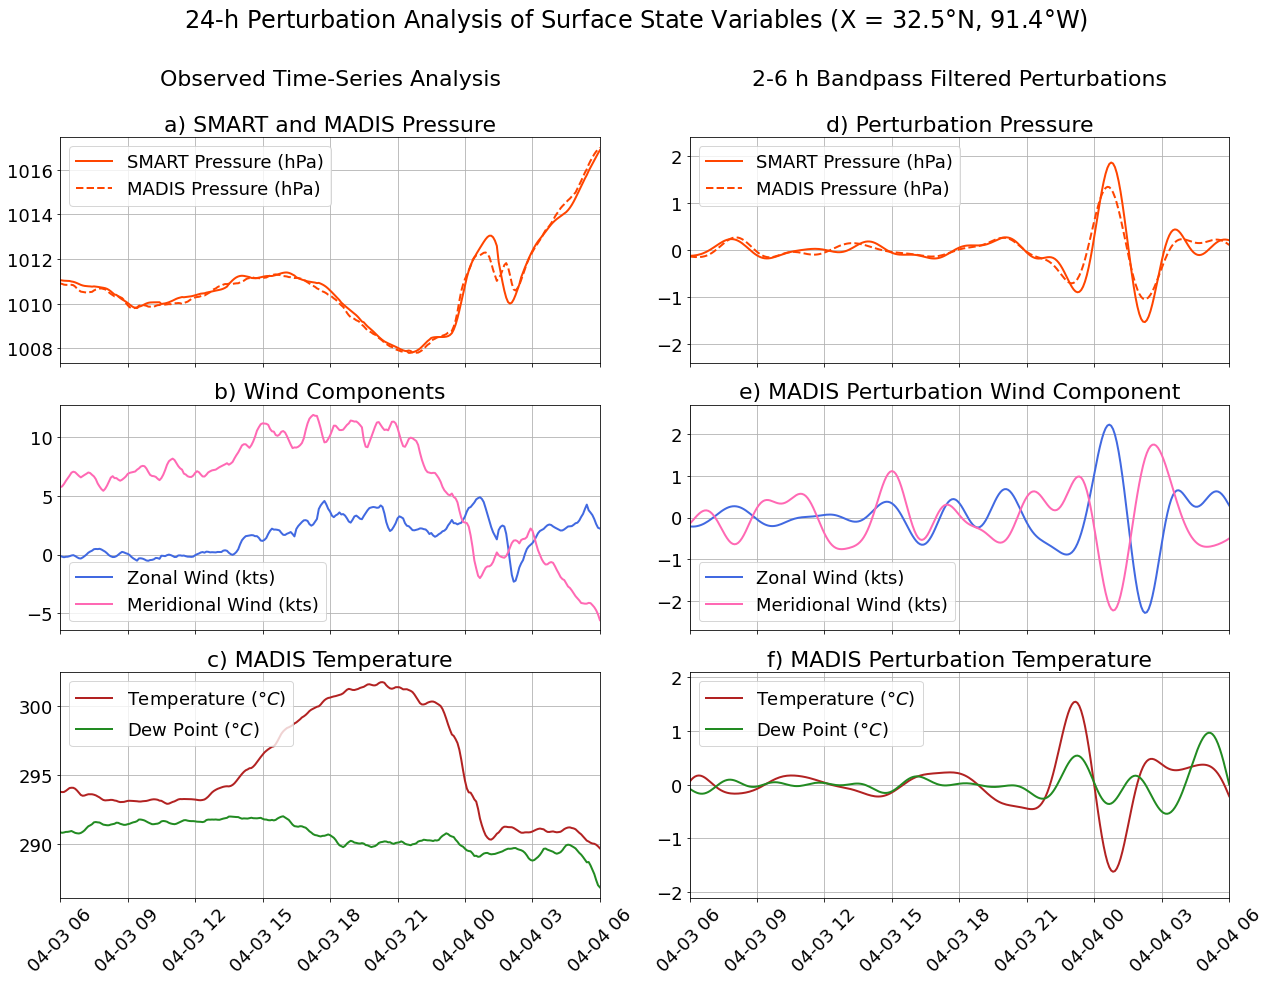

In [22]:
#get list of analysis times 
dts = np.array([datetime.utcfromtimestamp(d) for d in dg1['Valid'].values/1e9])

#Define function to set equal bounds for perturbations
def set_minmax(ax,vvar):
    #Find absolute min/max and set bounds to be symmetric about zero
    mmin = vvar.min()
    mmax = vvar.max()
    if (abs(mmin) > mmax):
        mmax = -1*mmin
    else:
        mmin = -1*mmax
    
    #Round bounds to nearest integer
    mmax = round(mmax+0.5,1)
    mmin = round(mmin-0.5,1)     
    ax.set_ylim([mmin,mmax])
    
#Plot time-series at inded of X marker depicted in the previous two figures

#Initialize figure
plt.figure(figsize=(18,14))
#Plot Altimeter (surface pressure) time-series
ax1 = plt.subplot(321)
ax1.plot(dts,alts_smart[:,yidx,xidx],'-k',color='orangered',lw=2,label='SMART Pressure (hPa)')
ax1.plot(dts,alts_madis[:,yidx,xidx],'--k',color='orangered',lw=2,label='MADIS Pressure (hPa)')
plt.title('Observed Time-Series Analysis\n\na) SMART and MADIS Pressure',fontsize=22)
plt.legend(numpoints=1,loc='best')
ax1.set_xticklabels([])
ax1.grid(True)
ax1.set_xlim([dts[0],dts[-1]])
#Plot perturbation pressure time-series
ax2 = plt.subplot(322)
ax2.plot(dts,alts_meso_smart[:,yidx,xidx],'-k',color='orangered',lw=2,label='SMART Pressure (hPa)')
ax2.plot(dts,alts_meso_madis[:,yidx,xidx],'--k',color='orangered',lw=2,label='MADIS Pressure (hPa)')
plt.title('2-6 h Bandpass Filtered Perturbations\n\nd) Perturbation Pressure',fontsize=22)
#Set y-axis limits
set_minmax(ax2,alts_meso_smart[:,yidx,xidx])
ax2.grid(True)
plt.legend(numpoints=1,loc='best')
ax2.set_xticklabels([])
ax2.set_xlim([dts[0],dts[-1]])

#Plot MADIS wind time-series
ax3 = plt.subplot(323)
ax3.plot(dts,uwnd[:,yidx,xidx],'-k',color='royalblue',lw=2,label='Zonal Wind (kts)')
ax3.plot(dts,vwnd[:,yidx,xidx],'-k',color='hotpink',lw=2,label='Meridional Wind (kts)')
ax3.grid(True)
ax3.set_xticklabels([])
plt.title('b) Wind Components',fontsize=22)
plt.legend(numpoints=1,loc='best')
ax3.set_xlim([dts[0],dts[-1]])

#Plot MADIS wind perturbation time-series
ax4 = plt.subplot(324)
ax4.plot(dts,uwnd_meso[:,yidx,xidx],'-k',color='royalblue',lw=2,label='Zonal Wind (kts)')
ax4.plot(dts,vwnd_meso[:,yidx,xidx],'-k',color='hotpink',lw=2,label='Meridional Wind (kts)')
plt.title('e) MADIS Perturbation Wind Component',fontsize=22)
#Set y-axis limits
set_minmax(ax4,vwnd_meso[:,yidx,xidx])
plt.legend(numpoints=1,loc='best')
ax4.grid(True)
ax4.set_xticklabels([])
ax4.set_xlim([dts[0],dts[-1]])

#Plot MADIS temperature and dew point temperature analysis time-series
ax5 = plt.subplot(325)
ax5.plot(dts,temp[:,yidx,xidx],'-k',color='firebrick',lw=2,label='Temperature $(\degree C)$')
ax5.plot(dts,dwpt[:,yidx,xidx],'-k',color='forestgreen',lw=2,label='Dew Point $(\degree C)$')
ax5.grid(True)
plt.legend(numpoints=1,loc='best')
plt.title('c) MADIS Temperature',fontsize=22)
plt.xticks(rotation=45)
ax5.set_xlim([dts[0],dts[-1]])

#Plot MADIS temperature and dew point temperature perturbations time-series
ax6 = plt.subplot(326)
ax6.plot(dts,temp_meso[:,yidx,xidx],'-k',color='firebrick',lw=2,label="Temperature $(\degree C$)")
ax6.plot(dts,dwpt_meso[:,yidx,xidx],'-k',color='forestgreen',lw=2,label='Dew Point $(\degree C)$')
#Set y-axis limits
set_minmax(ax6,temp_meso[:,yidx,xidx])
plt.title('f) MADIS Perturbation Temperature',fontsize=22)
ax6.grid(True)
plt.legend(numpoints=1,loc='best')
ax6.set_xlim([dts[0],dts[-1]])

plt.xticks(rotation=45)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.suptitle('24-h Perturbation Analysis of Surface State Variables (X = 32.5$\degree$N, 91.4$\degree$W)',fontsize=24)

In [25]:
#File starts 2-days and 6-hours into the month (648 five-min periods)
i0 = 648 
#Retrieve MADIS feature tracks
ds_madis_track = xr.open_dataset('../../../data/Cases/24hr_madis_positive_tracks.nc')
ds_madis_track['frame'].values = ds_madis_track['frame'].values+i0 #Correct frame number
#Get list of dates
s1 = '20180331_0000'
s2 = '20180501_0000'
dds = funcs.date_list(s1,s2,300,fmt)
dts2 = funcs.to_dt(dds,fmt)

#Retrieve smartphone feature tracks
ds_smart_track = xr.open_dataset('../../../data/Cases/24hr_smart_positive_tracks.nc')
ds_smart_track['frame'].values = ds_smart_track['frame'].values+i0

In [26]:
#Define function to plot MADIS and smartphone perturbation tracks.
def plot_track(d,ddate): 
    #Adjust time to account for starting 12-h after start of 24-h period
    d = d+144
    di = dds.index(ddate) #Get index of date in date list
    
    #Get 5-min reflectivity and altimeter analysis
    rfl_2d = dgr['REFL'][d].values
    #Set fontsize
    matplotlib.rcParams.update({'font.size': 18})

    #Mask altimeter anlaysis over water
    alts_meso_2d_smart = mask_grid(alts_meso_smart[d])
    #Smooth altimeter analysis for contouring
    alts_meso_2d_smart_smooth = ndimage.gaussian_filter(alts_meso_smart[d],sigma=2.5)
    
    #Mask altimeter anlaysis over water
    alts_meso_2d_madis = mask_grid(alts_meso_madis[d])
    #Smooth altimeter analysis for contouring
    alts_meso_2d_madis_smooth = ndimage.gaussian_filter(alts_meso_madis[d],sigma=2.5)
    
    #Initialize figure
    fig =plt.figure(figsize=(20,7))
    mmin=-2
    mmax=2
    levs = [-1.5,-1.25,-1,-0.75,0.75,1,1.25,1.5]

    #Plot Smartphone pressure perturbation analysis
    ax1 = plt.subplot2grid((2,4),(1, 0),colspan=2,projection=crs.PlateCarree())
    ax1 = plt.subplot(121,projection=crs.PlateCarree()) #define projection
    add_map(ax1,'dimgray',1) #Add States/borders
    #Plot feature track
    ccnt=0
    for dg in ds_smart_track.groupby('particle'):
        dg1 = dg[1]
        #Tracking starts on April 1 while perturbation file starts a day earlier, adjust frame by 1-day
        ts = dg1['frame'].values+288
        if (di in ts):    
            #Plot track
            ti = np.argwhere(ts==di).T[0][0]
            if (ccnt==0):
                plt.plot(dg1['lng'].values[:ti+1],dg1['lat'].values[:ti+1],'-ok',label='Feature Track')
            else:
                plt.plot(dg1['lng'].values[:ti+1],dg1['lat'].values[:ti+1],'-ok')     
            ccnt+=1
            
    add_gridlines(ax1,True,True,'k',18) #Add grid lines and x/y labels  
    im = ax1.imshow(alts_meso_2d_smart,origin='lower',extent=[minLng,maxLng,minLat,maxLat],cmap=cmr.prinsenvlag_r,vmin=mmin,vmax=mmax)
    #Contour pressure every 1 hPa
    CS = ax1.contour(X,Y,mask_grid(alts_meso_2d_smart_smooth),levels=levs,colors='dimgrey',alpha=1)
    CS2 = ax1.contour(X,Y,mask_grid(alts_meso_2d_smart_smooth),levels=[0.75],linewidths=2,colors='k',alpha=1)    
    ax1.clabel(CS, CS.levels, inline=True, fmt="%1.2f", fontsize=14, colors='dimgrey') #Label contours
    
    #Set grid bounds
    ax1.set_xlim([minLng,maxLng])
    ax1.set_ylim([minLat,maxLat])
    #Add plot title
    ax1.set_title('a) Smartphone Perturbation Pressure (hPa)')
    cb=plt.colorbar(im,fraction=0.025) #Shrink colorbar to fit plot height
    cb.ax.set_title('($hPa$)',y=1.02,fontsize=18) #Set colorbar title
    cb.ax.tick_params(labelsize=18) #Set colorbar tick size
    plt.legend(numpoints=1,loc='upper left')
    
    #Plot MADIS pressure perturbation analysis
    ax2 = plt.subplot(122,projection=crs.PlateCarree()) #define projection
    add_map(ax2,'dimgray',1) #Add States/borders
    #Plot feature track
    ccnt=0
    for dg in ds_madis_track.groupby('particle'):
        dg1 = dg[1]
        #Tracking starts on April 1 while perturbation file starts a day earlier, adjust frame by 1-day
        ts = dg1['frame'].values+288
        if (di in ts):    
            #Plot track
            ti = np.argwhere(ts==di).T[0][0]
            if (ccnt==0):
                plt.plot(dg1['lng'].values[:ti+1],dg1['lat'].values[:ti+1],'-ok',label='Feature Track')
            else:
                plt.plot(dg1['lng'].values[:ti+1],dg1['lat'].values[:ti+1],'-ok')                
            ccnt+=1
            
    add_gridlines(ax2,True,False,'k',18) #Add grid lines and x/y labels  
    im = ax2.imshow(alts_meso_2d_madis,origin='lower',extent=[minLng,maxLng,minLat,maxLat],cmap=cmr.prinsenvlag_r,vmin=mmin,vmax=mmax)
    #Contour pressure every 1 hPa
    CS = ax2.contour(X,Y,mask_grid(alts_meso_2d_madis_smooth),levels=levs,colors='dimgrey',alpha=1)    
    CS2 = ax2.contour(X,Y,mask_grid(alts_meso_2d_madis_smooth),levels=[0.75],linewidths=2,colors='k',alpha=1)    
    ax2.clabel(CS, CS.levels, inline=True, fmt="%1.2f", fontsize=14, colors='dimgrey') #Label contours
    
    #Set grid bounds
    ax2.set_xlim([minLng,maxLng])
    ax2.set_ylim([minLat,maxLat])
    ax2.set_title('b) MADIS Perturbation Pressure (hPa)')
    cb=plt.colorbar(im,fraction=0.025) #Shrink colorbar to fit plot height
    cb.ax.set_title('($hPa$)',y=1.02,fontsize=18) #Set colorbar title
    cb.ax.tick_params(labelsize=18) #Set colorbar tick size
    plt.legend(numpoints=1,loc='upper left')
    
    #Add subplot title and save figure
    fig.canvas.draw()
    plt.tight_layout(w_pad=1.5)
    plt.suptitle('Smartphone and MADIS Perturbation Tracking: '+ddate[9:13]+' UTC '+ddate[6:8]+'/'+ddate[4:6]+'/'+ddate[0:4],fontsize=22)
    
    cnt = d-144
    if (cnt < 10):
        cs = '00'+str(cnt)
    elif ((cnt >= 10) and (cnt < 100)):
        cs = '0'+str(cnt)
    else:
        cs = str(cnt)
        
    plt.savefig('../../../Plots/Analysis/surface_track_analysis_'+cs+'.png')
    
#print(len(dtlist))
#dd = 225
#plot_pert_one(dd,dtlist[dd])

In [27]:
#Remove old perturbation tracking images
os.system('rm -rf ../../../Plots/Analysis/surface_track_analysis*')    
#Loop through date list and save perturbation tracking figures
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(plot_track)(d,ddate) for d,ddate in enumerate(dtlist[144:]))

/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribut

/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribut

/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribut

/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribut

/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribut

/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute 

/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribut

/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribut

/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribut

/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribut

/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribut

/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribut

/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribut

In [28]:
#If animation (mp4 movie) already exists, remove it so ffmpeg won't ask to overwrite
if os.path.isfile('../../../Plots/Analysis/surface_track_analysis.mp4'):
    os.system('rm -rf ../../../Plots/Analysis/surface_track_analysis.mp4')
#Create mp4 movie from 5-min pressure perturbation tracking anlayses saved as pngs
os.system('ffmpeg -r 12 -f image2 -s 1920x1080 -i ../../../Plots/Analysis/surface_track_analysis_%03d.png -c:v libx264 -pix_fmt yuv420p ../../../Plots/Analysis/surface_track_analysis.mp4')
#(Below) display video of perturbation tracking

ffmpeg version 4.1.3 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/disk/p/cmcnich/miniconda3 --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1556785800657/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 22.100 / 56. 22.100
  libavcodec     58. 35.100 / 58. 35.100
  libavformat    58. 20.100 / 58. 20.100
  libavdevice    58.  5.100 / 58.  5.100
  libavfilter     7. 40.101 /  7. 40.101
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  3.100 /  5.  3.100
  libswresample   3.  3.100 /  3.  3.100
  libpostproc    55.  3.100 / 55.  3.100
Input #0, image2, from '../../../Plots/Analysis/surface

0

In [29]:
%%HTML
<div align="middle">
<video width="100%" controls>
      <source src = "../../../Plots/Analysis/surface_track_analysis.mp4" type="video/mp4">
</video></div>

/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribut

/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribut

/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribut

/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribut

/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribut

/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribut

/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribut